In [41]:
!pip install tf-nightly-gpu-2.0-preview
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
import pickle
from google.colab.patches import cv2_imshow
from keras.preprocessing.image import ImageDataGenerator


Found GPU at: /device:GPU:0


Using TensorFlow backend.


In [0]:
#the follow are steps to load data from Google Drive
from google.colab import drive

In [0]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!ls './gdrive/My Drive/Career Work/SERIUS/Pill Images V2' #we can use ! to run terminal commands

'Test Set'  'Train Set'


In [0]:
DATA_PATH_TRAIN='./gdrive/My Drive/Career Work/SERIUS/Pill Images V2/Train Set'
DATA_PATH_TEST='./gdrive/My Drive/Career Work/SERIUS/Pill Images V2/Test Set'
medication_array=['Pill1','Pill2','Pill3','Pill4','Pill5','Pill6']
colour_array=['Red','Orange','White','Black','Dark Red','Blue']
shape=['Circular','Elliptical']
IMG_SIZE=150


In [0]:
def process_image(img_array,IMG_SIZE): 
  crop_img = img_array[250:750, 700:1200] #first crop the image
  
  #next find the contours of the image
  new_array=cv2.resize(crop_img,(IMG_SIZE,IMG_SIZE)) #resize every image before passing it in
  hsv = cv2.cvtColor(new_array, cv2.COLOR_BGR2HSV) #convert image to hsv

  ret, thresh = cv2.threshold(hsv, 127, 255, 0) #threshold our hsv

  #im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  #cv2.drawContours(img, contours, -1, (0,255,0), 3)
  plt.imshow(hsv,cmap='Greys_r')
  #plt.show()    
  return hsv

Pill1
Pill2
Pill3
Pill4
Pill5
Pill6
Pill1
Pill2
Pill3
Pill4
Pill5
Pill6


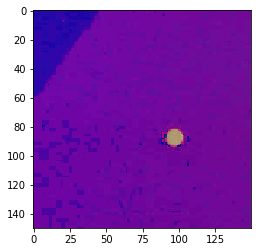

In [0]:
medication_array=['Pill1','Pill2','Pill3','Pill4','Pill5','Pill6']
colour_array=['Red','Orange','White','Black','Dark Red','Blue']
shape=['Circular','Elliptical']

class dataset:
  #in python, don't define any variables here, another it doesn't not belong to the object itself and will get mutated everything another class is called
  
  def __init__(self,path):
    self.PATH=path
    self.x=[]
    self.y=[]
    self.shapes=[]
    self.colours=[]
    self.data=[] #entire dataset
    
    
  def create_data(self):
    for pill in medication_array:
      #local variables
      print(pill)
      my_path=os.path.join(self.PATH,pill)
      classnum=medication_array.index(pill) #indexed from 0 to 5 (will add one when showing results)
      pill_shape=shape[1]
      
      if classnum==0 or classnum==1 or classnum==3:
        pill_shape=shape[0]
        
      for image in os.listdir(my_path):
        try:
          img_array=cv2.imread(os.path.join(my_path,image))
          new_array=process_image(img_array,IMG_SIZE)
          self.data.append([new_array,classnum,pill_shape,colour_array[classnum]])
        except Exception as e:
          print('f')
          pass
    random.shuffle(self.data)
    
  def structure_data(self):
    for image, label, pill_shape, colour in self.data:
      self.x.append(image)
      self.y.append(label)
      self.shapes.append(pill_shape)
      self.colours.append(colour)
    self.x=np.array(self.x).reshape(-1,IMG_SIZE,IMG_SIZE,3)
          

training=dataset(DATA_PATH_TRAIN)
training.create_data()
training.structure_data()

testing=dataset(DATA_PATH_TEST)
testing.create_data()
testing.structure_data()


In [0]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)

In [0]:
def show_RBG(image_in):
  bgrimg = cv2.cvtColor(image_in, cv2.COLOR_HSV2BGR)
  image = cv2.cvtColor(bgrimg, cv2.COLOR_BGR2RGB)
  pixels = np.array(image)
  plt.imshow(pixels)
  plt.show()

In [0]:
pickle_out=open('train_x.pickle','wb')
pickle.dump(training.x,pickle_out)
pickle_out.close();

pickle_out=open('train_y.pickle','wb')
pickle.dump(training.y,pickle_out)
pickle_out.close();

pickle_out=open('test_x.pickle','wb')
pickle.dump(testing.x,pickle_out)
pickle_out.close();

pickle_out=open('test_y.pickle','wb')
pickle.dump(testing.y,pickle_out)
pickle_out.close();


In [45]:
test_x=[]
train_x=[]
test_y=[]
train_y=[]

pickle_in=open('test_x.pickle','rb')
test_x=pickle.load(pickle_in)

pickle_in=open('test_y.pickle','rb')
test_y=pickle.load(pickle_in)


pickle_in=open('train_x.pickle','rb')
train_x=pickle.load(pickle_in)

pickle_in=open('train_y.pickle','rb')
train_y=pickle.load(pickle_in)
print(len(test_y))
print(test_x.shape)
test_x=test_x/255.0
train_x=train_x/255.0


242
(242, 150, 150, 3)


In [46]:
def createModel():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=train_x.shape[1:]),
        #input shape is IMG_SIZExIMG_SIZEx3bytes coloured (HSV))
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(), #flattens the dataset for our input layer
        tf.keras.layers.Dense(512,activation=tf.nn.relu),
        tf.keras.layers.Dense(6,activation='softmax') #sigmoid for final layer
    ])
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model
model=createModel()
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 18496)           

In [47]:

model.fit(train_x,train_y, validation_split=0.2, epochs=5, batch_size=30, callbacks = [cp_callback])

Train on 767 samples, validate on 192 samples
Epoch 1/5
750/767 [============================>.] - ETA: 0s - loss: 1.3453 - accuracy: 0.4973
Epoch 00001: saving model to training_1/cp.ckpt
767/767 [==============================] - 1s 2ms/sample - loss: 1.3214 - accuracy: 0.5072 - val_loss: 0.3047 - val_accuracy: 0.9427
Epoch 2/5
720/767 [===========================>..] - ETA: 0s - loss: 0.1957 - accuracy: 0.9556
Epoch 00002: saving model to training_1/cp.ckpt
767/767 [==============================] - 1s 1ms/sample - loss: 0.1903 - accuracy: 0.9570 - val_loss: 0.0710 - val_accuracy: 0.9844
Epoch 3/5
750/767 [============================>.] - ETA: 0s - loss: 0.0254 - accuracy: 0.9973
Epoch 00003: saving model to training_1/cp.ckpt
767/767 [==============================] - 1s 1ms/sample - loss: 0.0253 - accuracy: 0.9974 - val_loss: 0.0355 - val_accuracy: 0.9948
Epoch 4/5
750/767 [============================>.] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000
Epoch 00004: saving model to tr

In [48]:

newModel=createModel()
newModel.evaluate(test_x,test_y)
newModel.load_weights(checkpoint_path)
newModel.evaluate(test_x,test_y)

242/242 [==============================] - 0s 517us/sample - loss: 0.0017 - accuracy: 1.0000


[0.0017480696472728986, 1.0]

In [54]:
ypr = model.predict(test_x)
model.evaluate(test_x,test_y)
model.save('Pill Predictor V5')

242/242 [==============================] - 0s 531us/sample - loss: 0.0017 - accuracy: 1.0000


In [0]:
def prepare(filepath):
    IMG_SIZE=150
    img_array=cv2.imread(filepath)
    new_array=process_image(img_array)
    return new_array.reshape(-1,IMG_SIZE,IMG_SIZE,1) 

In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
yprr = np.argmax(ypr, axis=1)

In [53]:
confusion_matrix(test_y, yprr)

array([[40,  0,  0,  0,  0,  0],
       [ 0, 41,  0,  0,  0,  0],
       [ 0,  0, 41,  0,  0,  0],
       [ 0,  0,  0, 38,  0,  0],
       [ 0,  0,  0,  0, 41,  0],
       [ 0,  0,  0,  0,  0, 41]])